In [40]:
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.sparse import csr_matrix
from convert import convert
import seaborn as sns

import plotly.plotly as py

py.sign_in('ayagoz', '2rcpqwmjz4')
%matplotlib inline

In [41]:
# 003_S_2374_1 - subject_id_file,
# 003_S_2374 - subject_id, 1 - scan_id

path = 'connectomics/ADNI/ADNI/Data/matrices/'
matrices = []
all_matrices = pd.DataFrame(columns = ['subject_id_file','subject_id','scan_id', 'matrix', 'target'])

# importing data
for foldername in sorted(os.listdir(path)):
    for filename in sorted(os.listdir(path+foldername)):
        if 'NORM' not in filename:
            mat = np.genfromtxt(path+foldername+'/'+filename)
            subject_id_file = foldername
            subject_id = foldername[:-2]
            scan_id = foldername[-1:]
            
            mat = np.delete(mat, [3,38], 1)
            mat = np.delete(mat, [3,38], 0)
            np.fill_diagonal(mat,0)         
            subject_data = convert(mat, mode = 'mat2vec')
            single_subject = pd.DataFrame(data = [[subject_id_file, subject_id, scan_id, subject_data, np.nan]],
                                          columns = ['subject_id_file','subject_id','scan_id', 'matrix', 'target'])
            all_matrices = all_matrices.append(single_subject)
            
all_matrices.index = all_matrices.subject_id_file
subject_data = pd.read_csv('connectomics/ADNI/ADNI/Data/ADNI_subject_list.csv')
subject_id_names = np.array(all_matrices['subject_id_file'])

#importing target variables
for name in subject_id_names:
    smth = subject_data.loc[subject_data['Subject ID'] == name[:-2]]['DX Group'].dropna()
    un_smth = np.unique(smth)
    try:
        val = un_smth[0].replace(' ', '')
        all_matrices.set_value(name, 'target', val)
    except:
        pass
    
#drop objects without any target
all_matrices.dropna(inplace = True)
data = all_matrices.copy()
data.shape

(807, 5)

In [43]:
#003_S_0908_1_connect_dil_centerOfGravities
aid = data['subject_id_file'].tolist()
flag = 1
no_centers = []
path = 'connectomics/ADNI/ADNI/adni2_centers/'
centers = pd.DataFrame(columns = ['subject_id', 'scan_id','coordinate'])
for idx in aid:
    vec = pd.read_csv(path+'/'+idx+'_connect_dil_centerOfGravities.txt')
    vec.drop(vec.index[[3,38]], inplace = True)
    vec.__delitem__('Unnamed: 7')
    vec.__delitem__('region')
    vec.__delitem__('voxel_cordX')
    vec.__delitem__('voxel_cordY')
    vec.__delitem__('voxel_cordZ')
    mat = vec.as_matrix()
    if (mat.all() == 0):
        flag = 0
        no_centers +=[idx]
    #filename = filename[:12]
    subject_id = idx[:-2]
    scan_id = idx[-1:]
    single_subject = pd.DataFrame(data = [[subject_id, scan_id, mat]], 
                                  columns = ['subject_id', 'scan_id','coordinate'])
    if (flag != 0 ):
        centers = centers.append(single_subject)
    flag = 1
centers.index = centers.subject_id
centers.shape , no_centers

((802, 3),
 ['003_S_4644_1',
  '007_S_2106_1',
  '127_S_4992_1',
  '127_S_5056_1',
  '127_S_5058_1'])

In [44]:
for idx in no_centers:
    data = data[data.subject_id_file != idx]
ucenters = centers[centers.scan_id == '1']
udata = data[data.scan_id == '1']

In [45]:
all_nodes = np.array(ucenters['coordinate'])

type(all_nodes), all_nodes.shape, ucenters['subject_id'][13]

(numpy.ndarray, (235,), '003_S_4839')

In [46]:
coord = np.array(all_nodes.sum()/235).T
coord.shape, type(coord)

((3, 68), numpy.ndarray)

In [50]:
m = convert(udata['matrix'][0])

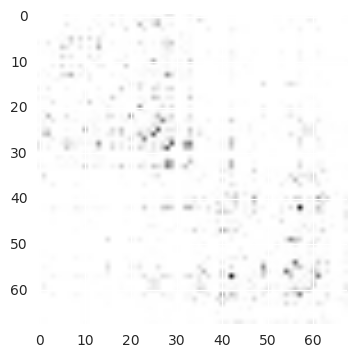

In [51]:
plt.imshow(m)

In [75]:
G = ig.Graph()
G = G.Adjacency(np.where(m>0,1,0).tolist())

In [77]:
label = (np.zeros(34)).tolist() + (np.ones(34)).tolist()

In [78]:
from plotly.graph_objs import *
layt=G.layout('kk', dim=3)
print(layt)

Xn=coord[0].tolist() # x-coordinates of nodes
Yn=coord[1].tolist() # y-coordinates
Zn=coord[2].tolist() # z-coordinates
Xe=[]
Ye=[]
Ze=[]

for node in G.get_edgelist():
    Xe+=[Xn[node[0]-1],Xn[node[1]-1], None]# x-coordinates of edge ends
    Ye+=[Yn[node[0]-1],Yn[node[1]-1], None]
    Ze+=[Zn[node[0]-1],Zn[node[1]-1], None]


<Layout with 68 vertices and 3 dimensions>


In [79]:
trace1=Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
               line=Line(color='rgb(125,125,125)', width=.5),
               hoverinfo='none'
               )
trace2=Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               marker=Marker(symbol='dot',
                             size=6,
                             color = label,
                             colorscale='Viridis',
                             line=Line(color='rgb(50,50,50)', width=0.5)
                             ),
               hoverinfo = 'none'
               )

In [80]:
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

In [81]:
layout = Layout(
         title="Visualization",
         width=1000,
         height=1000,
         showlegend=False,
         scene=Scene(
         xaxis=XAxis(axis),
         yaxis=YAxis(axis),
         zaxis=ZAxis(axis),
        ),
     margin=Margin(
        t=100
    ),
    hovermode='closest',
    annotations=Annotations([
           Annotation(
           showarrow=False,
            text="",
            xref='paper',
            yref='paper',
            x=0,
            y=0.1,
            xanchor='left',
            yanchor='bottom',
            font=Font(
            size=14
            )
            )
        ])  )

In [82]:
data=Data([trace1, trace2])
fig=Figure(data=data, layout = layout)

py.iplot(fig, filename='Connectome')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~ayagoz/0 or inside your plot.ly account where it is named 'Connectome'
